<a href="https://colab.research.google.com/github/ryan-ng04/mri-based-brain-tumor-classifier/blob/main/MRI_Based_Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import cv2
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn import metrics
import os
import gdown # for downloading from google drive

In [ ]:
def plot_digits_with_predictions(model, data, labels, img_size=299, rows=10):
    fig, ax = plt.subplots(rows, 10, figsize=(16, 20),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.5, wspace=0.01)
    for i, axi in enumerate(ax.flat):
        if i < data.shape[0]:
          im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
          pred_label = model(torch.tensor(data[i]).float()).item()
          drawColor = 'black'
          if (pred_label>0) != (labels[i]>0.5):
            drawColor = 'red'
          axi.set_title("label:{}\npred:{:1.2f}".format(labels[i],pred_label), color=drawColor)

In [ ]:
import os
import cv2
import numpy as np

def load_brain_data(notumor_data_loc=None, meningioma_data_loc=None, glioma_data_loc=None, pituitary_data_loc=None):
  data = []
  labels = []

  label_map = {
      0: notumor_data_loc,
      1: meningioma_data_loc,
      2: glioma_data_loc,
      3: pituitary_data_loc
  }

  for label, folder in label_map.items():
      if folder:
          for imgname in os.listdir(folder):
              if imgname.startswith('.'):  # Skip hidden files like .DS_Store
                  continue
              img_path = os.path.join(folder, imgname)
              img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
              if img is not None:
                  img = cv2.resize(img, (128, 128))
                  img = img.flatten()
                  data.append(img)
                  labels.append(label)

  return np.array(data), np.array(labels)


#Example usage:

In [ ]:
!gdown 1R2-tZpQfHs9WkZujsepr3YUNZ2JJLud8 -O Training.zip
!unzip -qo /content/Training.zip

Downloading...
From (original): https://drive.google.com/uc?id=1R2-tZpQfHs9WkZujsepr3YUNZ2JJLud8
From (redirected): https://drive.google.com/uc?id=1R2-tZpQfHs9WkZujsepr3YUNZ2JJLud8&confirm=t&uuid=11a9d6e8-e552-422b-a25f-ded1c6d53573
To: /content/Training.zip
100% 132M/132M [00:02<00:00, 51.5MB/s]


In [ ]:
!gdown 1g0EJu604RM7QsxPdMz5AmYN8ApoveQY5 -O Testing.zip
!unzip -qo /content/Testing.zip

Downloading...
From: https://drive.google.com/uc?id=1g0EJu604RM7QsxPdMz5AmYN8ApoveQY5
To: /content/Testing.zip
100% 26.1M/26.1M [00:00<00:00, 44.8MB/s]


In [ ]:
categories = os.listdir("/content/Training/")
print(categories)

['pituitary', 'notumor', 'glioma', 'meningioma', '.DS_Store']


In [ ]:
x_train, y_train = load_brain_data(
    "/content/Training/notumor",
    "/content/Training/meningioma",
    "/content/Training/glioma",
    "/content/Training/pituitary"
)


x_test, y_test = load_brain_data(
    "/content/Testing/notumor",
    "/content/Testing/meningioma",
    "/content/Testing/glioma",
    "/content/Testing/pituitary"
)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(5712, 16384)
(5712,)
(1311, 16384)
(1311,)


In [ ]:
def pretendModel(mydata):
    return torch.tensor(np.zeros((1, 1)))

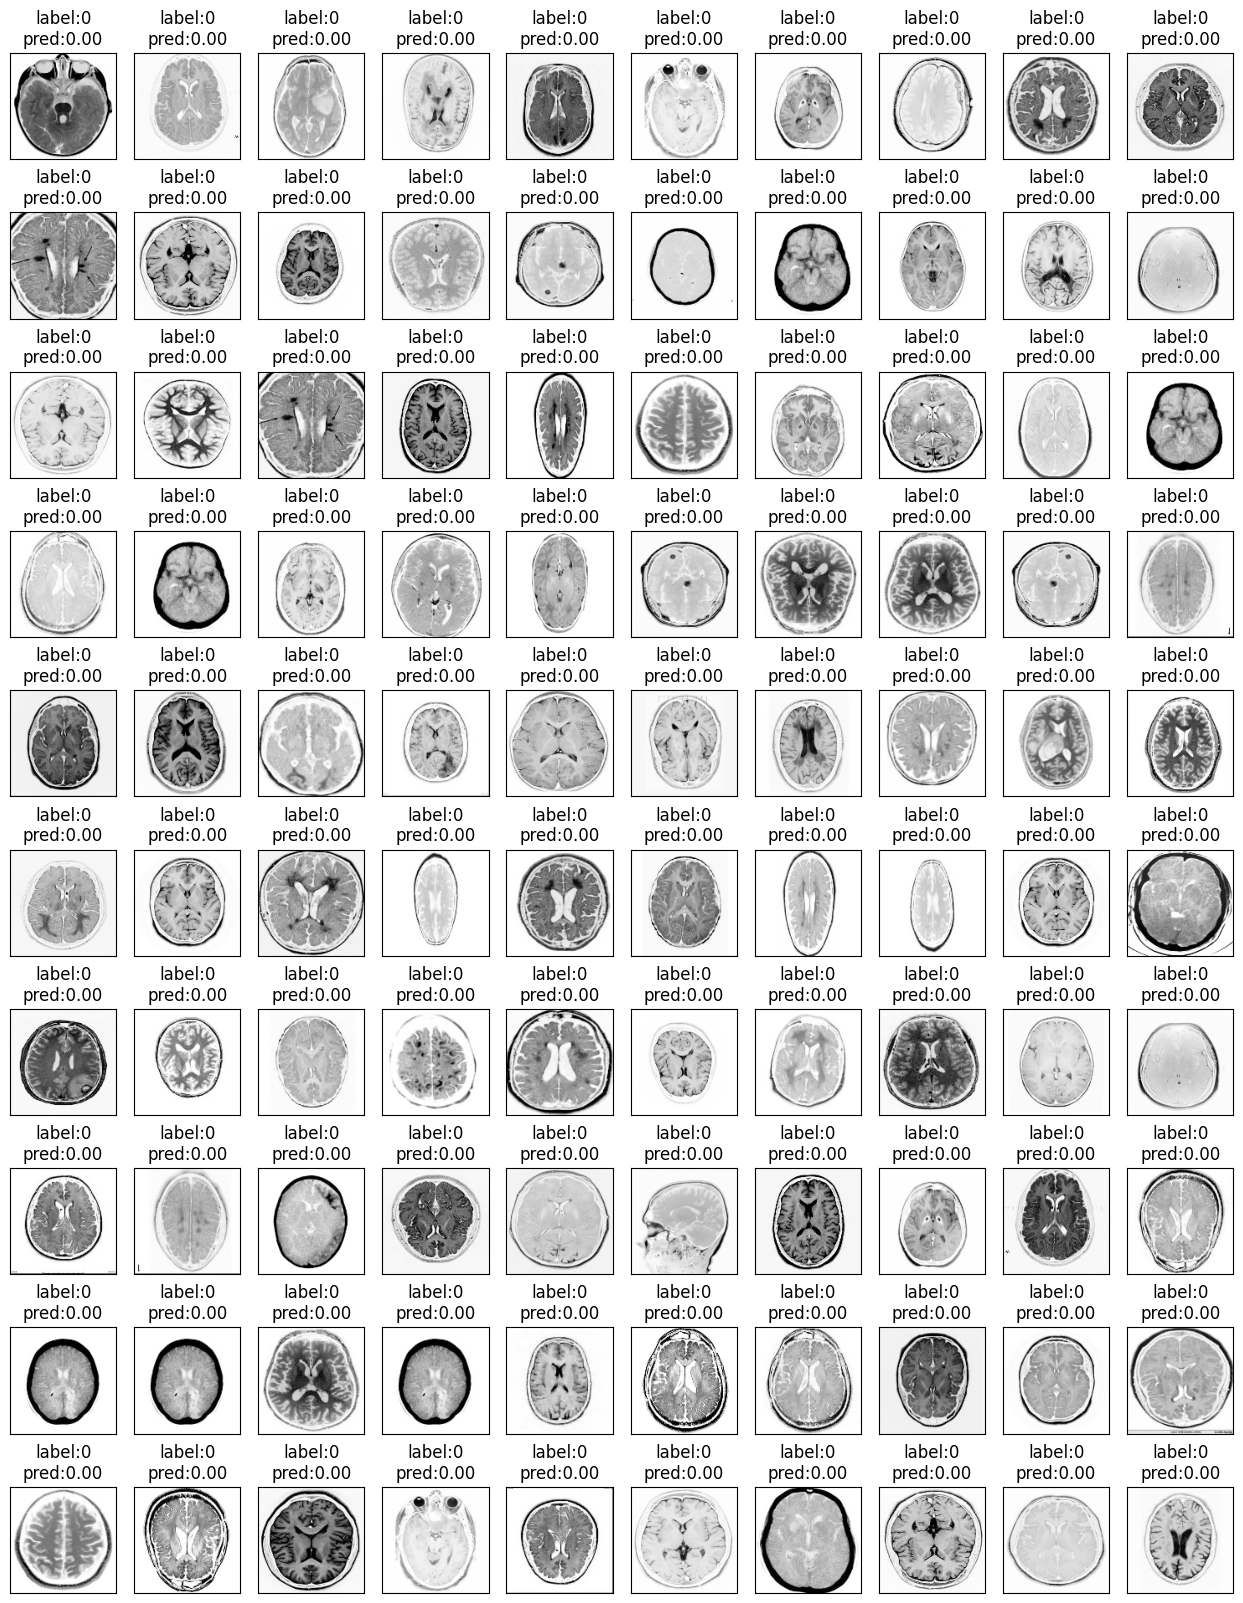

In [ ]:
plot_digits_with_predictions(pretendModel, x_test, y_test, img_size=128)

In [ ]:
# print(training_label_is_healthy_brains.shape)
# print(testing_label_is_healthy_brains.shape)

In [ ]:
class NumpyDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, input_array, target_output_array):
    'Initialization'
    self.input_tensor = torch.from_numpy(input_array).float()
    self.output_tensor = torch.from_numpy(target_output_array).long()

  def __len__(self):
      'Denotes the total number of samples'
      return len(self.input_tensor)

  def __getitem__(self, index):
      'Generates one sample of data'
      # Load data and get label
      X = self.input_tensor[index].view(1, 128, 128)
      y = self.output_tensor[index]

      return X, y

In [ ]:
training_dataset = NumpyDataset(x_train, y_train)
testing_dataset = NumpyDataset(x_test, y_test)

In [ ]:
def test(network, test_loader, loss_function):
  network.eval() #updates any network layers that behave differently in training and execution
  test_loss = 0
  num_batches = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += loss_function(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      num_batches += 1
  test_loss /= num_batches
  #print('\nTest set: Avg. loss: {:.4f})\n'.format(test_loss))
  return test_loss

def logResults(epoch, num_epochs, train_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, print_interval=1000):
  if (epoch%print_interval == 0):  print('Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f' %(epoch+1, num_epochs, train_loss, test_loss))
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  epoch_counter.append(epoch)

def graphLoss(epoch_counter, train_loss_hist, test_loss_hist, loss_name="Loss", start = 0):
  fig = plt.figure()
  plt.plot(epoch_counter[start:], train_loss_hist[start:], color='blue')
  plt.plot(epoch_counter[start:], test_loss_hist[start:], color='red')
  plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
  plt.xlabel('#Epochs')
  plt.ylabel(loss_name)

def computeLabelAccuracy(networkModel, data_loader, label_text=""):
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in data_loader:
      output = networkModel(data)
      pred = output.data.max(1, keepdim=True)[1]  #Check if the maximum/largest output class matches the label
      correct += pred.eq(target.data.view_as(pred)).sum()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))

def graphConfusionMatrix(test_datset, num_samples=10000):
  data_generator = torch.utils.data.DataLoader(test_datset, batch_size=num_samples)
  data_enumerator = enumerate(data_generator)
  _, (images,labels) = next(data_enumerator)
  with torch.no_grad():
      pred_catigories = network(images) #all 10 values
      pred_labels = pred_catigories.data.max(1, keepdim=True)[1] #only the highest value is the final prediction
  conf_mat = confusion_matrix(labels.numpy(), pred_labels.numpy(), normalize = "pred")
  plt.figure(figsize=(8,5))
  sns.heatmap(conf_mat, annot=True, fmt="0.2f", xticklabels = classes, yticklabels = classes,
              cmap = "gnuplot") #colormaps: gnuplot hot RdPu inferno viridis BuPu RdBu_r coolwarm
  plt.xlabel("Target Class")
  plt.ylabel("Predicted Class")

In [ ]:
def train(network,  data_generator, loss_function, optimize, batch_logging = 100):
  network.train() #updates any network layers that behave differently in training and execution
  avg_loss = 0
  num_batches = 0
  for batch, (input_data, target_output) in enumerate(data_generator):
    optimizer.zero_grad()                            # Gradients need to be reset each batch
    prediction = network(input_data)                 # Forward pass: compute the output class given a image
    loss = loss_function(prediction, target_output)  # Compute the loss: difference between the output and correct result
    loss.backward()                                  # Backward pass: compute the gradients of the model with respect to the loss
    optimizer.step()
    avg_loss += loss.item()
    num_batches += 1
    if ((batch+1)%batch_logging == 0): #Print info every "batch_logging" steps [NEW]
      print('Batch [%d/%d], Train Loss: %.4f' %(batch+1, len(data_generator.dataset)/len(target_output), avg_loss/num_batches))
  return avg_loss/num_batches

In [ ]:
def trainAndGraph(network, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, early_stopping=False, logging_interval=1):
  #Arrays to store training history
  test_loss_history = []
  epoch_counter = []
  train_loss_history = []
  last_loss = 999999
  best_loss = 999999
  for epoch in range(num_epochs):
    avg_loss = train(network, training_generator, loss_function, optimizer)
    test_loss = test(network, testing_generator, loss_function)
    logResults(epoch, num_epochs, avg_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, logging_interval)
    if (early_stopping and test_loss > last_loss):
      break
    if (test_loss < best_loss):
      best_loss = test_loss
      torch.save(network.state_dict(), 'best_model.pt')
    last_loss = test_loss
    old_params = network.parameters()

  graphLoss(epoch_counter, train_loss_history, test_loss_history)

In [ ]:
def drawPredictionsBrains(networkModel, dataset, num_rows=5, num_cols=12, skip_batches=0):
    classes = ['notumor', 'meningioma', 'glioma', 'pituitary']
    data_generator = torch.utils.data.DataLoader(dataset, batch_size=num_rows*num_cols, shuffle=True)
    data_enumerator = enumerate(data_generator)

    for i in range(skip_batches):
        _, (images, labels) = next(data_enumerator)

    _, (images, labels) = next(data_enumerator)

    with torch.no_grad():
        outputs = networkModel(images)
        _, preds = torch.max(outputs, 1)

    for row in range(num_rows):
        fig = plt.figure(figsize=(num_cols+6, 5))
        for i in range(num_cols):
            plt.subplot(1, num_cols, i+1)
            cur = i + row*num_cols
            drawColor = 'black'
            if preds[cur].item() != labels[cur].item():
                drawColor = 'red'
            img = images[cur].numpy().squeeze()
            plt.imshow(img, cmap='gray')
            plt.title(f"Pred: {classes[preds[cur].item()]}\nTrue: {classes[labels[cur].item()]}",
                     color=drawColor, fontsize=8)
            plt.xticks([])
            plt.yticks([])

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        identity = x  # Store the input for the skip connection

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out += identity  # Add the skip connection
        out = F.relu(out)  # Apply activation

        return out

In [ ]:
class CNN_Variant(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN_Variant, self).__init__()

        # Conv Layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        # residual block at 32 channels
        self.res_block1 = ResidualBlock(32)

        self.conv4 = nn.Conv2d(32, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout2d = nn.Dropout2d(0.2)

        # residual block at 128 channels
        self.res_block2 = ResidualBlock(128)

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)

        x = self.res_block1(x)
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.dropout2d(x)
        x = F.max_pool2d(x, 2)

        x = self.res_block2(x)
        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


Loaded Data
Epoch [1/20], Train Loss: 0.8026, Test Loss: 0.6074
Epoch [2/20], Train Loss: 0.5484, Test Loss: 0.5589
Epoch [3/20], Train Loss: 0.4526, Test Loss: 0.4654
Epoch [4/20], Train Loss: 0.3934, Test Loss: 0.4233
Epoch [5/20], Train Loss: 0.3491, Test Loss: 0.3851
Epoch [6/20], Train Loss: 0.3186, Test Loss: 0.3334
Epoch [7/20], Train Loss: 0.2978, Test Loss: 0.3381

Train Set: Accuracy: 5250/5712 (91.9%)

Test Set: Accuracy: 1106/1311 (84.4%)


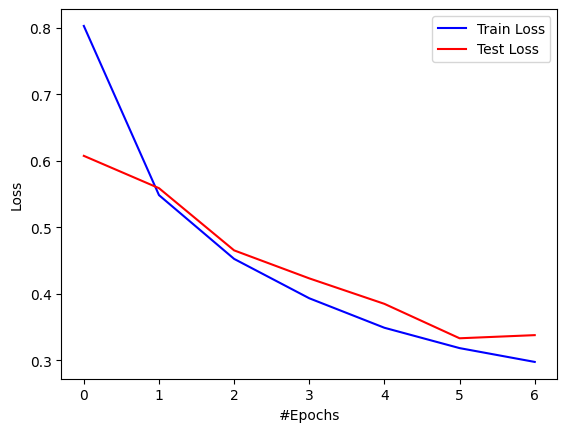

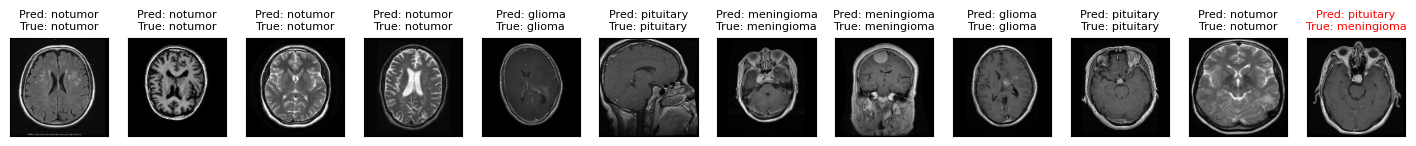

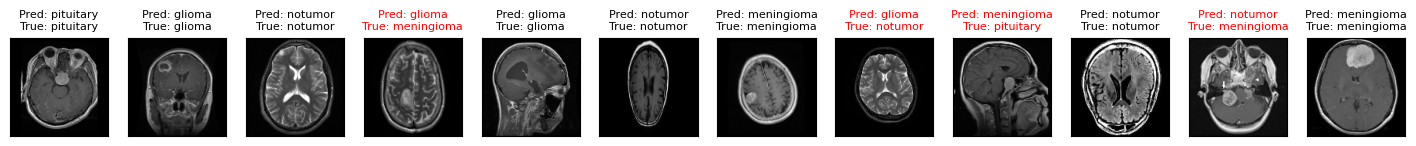

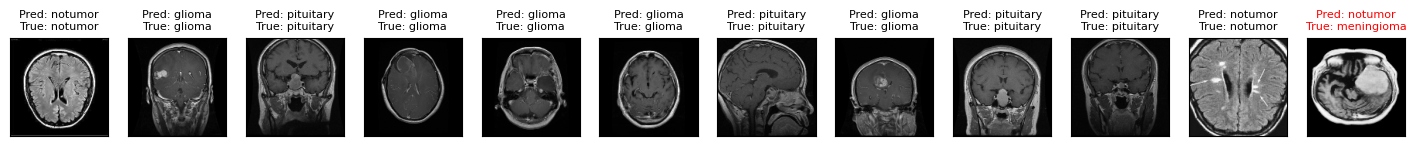

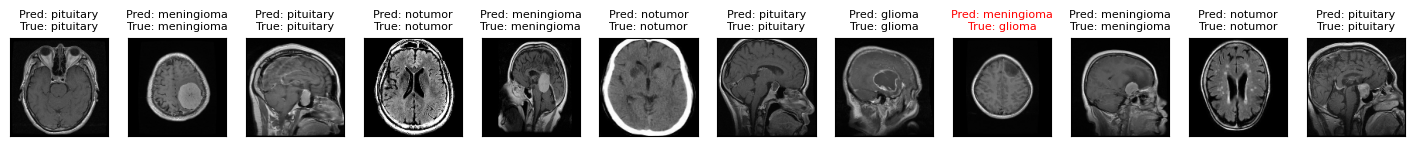

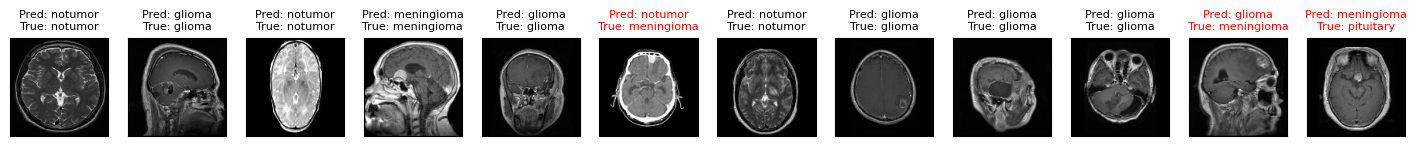

In [ ]:
# Training parameters
num_epochs = 20
print_interval = 1
learning_rate = 0.0001
batch_size = 100

# Create model
network = CNN_Variant(num_classes=4)

# Set optimizer and loss function
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

# Load the data and split it into batches
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

print("Loaded Data")

# Train the model and visualize training progress
trainAndGraph(network, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)

# Evaluate on train and test sets
computeLabelAccuracy(network, training_generator, "Train Set")
computeLabelAccuracy(network, testing_generator, "Test Set")

# Visualize predictions
drawPredictionsBrains(network, testing_dataset, 5, 12, 0)


In [ ]:
from collections import Counter
print(Counter(y_train))

Counter({np.int64(0): 1595, np.int64(3): 1457, np.int64(1): 1339, np.int64(2): 1321})


In [ ]:
from collections import Counter

all_preds = []
all_labels = []

network.eval()
with torch.no_grad():
    for images, labels in testing_generator:
        outputs = network(images)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

print("Prediction class counts:", Counter(all_preds))
print("True class counts:", Counter(all_labels))


Prediction class counts: Counter({0: 443, 2: 316, 3: 283, 1: 269})
True class counts: Counter({0: 405, 1: 306, 2: 300, 3: 300})


AUC: 0.9851034257215272


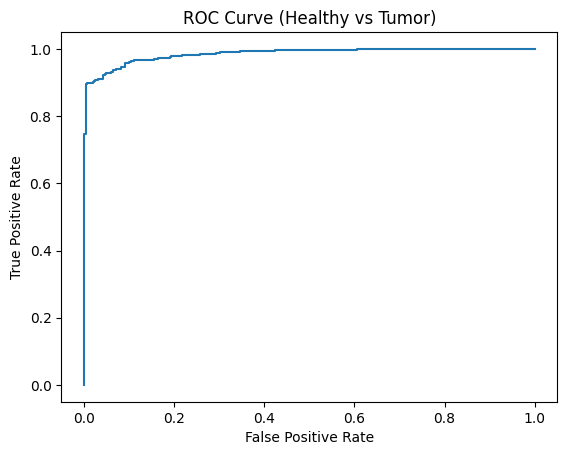

Precision 0.9758064516129032
Recall 0.934878587196468
F1 0.9549041713641488


In [ ]:
test_labels = []
test_probs = []
test_preds = []

network.eval()
with torch.no_grad():
    for images, labels in testing_generator:
        outputs = network(images)
        probs = F.softmax(outputs, dim=1)
        preds = outputs.argmax(dim=1)
        test_labels.extend(labels.numpy())
        test_probs.extend(probs.numpy())
        test_preds.extend(preds.numpy())

test_labels = np.array(test_labels)
test_probs = np.array(test_probs)
test_preds = np.array(test_preds)

binary_test_labels = (test_labels > 0).astype(int)
binary_test_probs = test_probs[:, 1:].sum(axis=1)

# ROC Curve
fpr, tpr, thresholds = metrics.roc_curve(binary_test_labels, binary_test_probs)
plt.plot(fpr, tpr)
plt.title("ROC Curve (Healthy vs Tumor)")
print("AUC:", metrics.auc(fpr, tpr))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Precision, Recall, F1
p, r, f, count = metrics.precision_recall_fscore_support(
    binary_test_labels,
    test_preds > 0,
    average='binary'
)
print("Precision", p)
print("Recall", r)
print("F1", f)

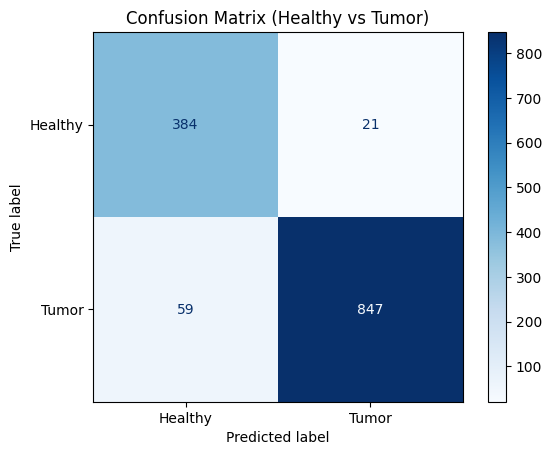

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#using imports
test_labels = []
test_probs = []
test_preds = []

network.eval()
with torch.no_grad():
    for images, labels in testing_generator:
        outputs = network(images)
        probs = F.softmax(outputs, dim=1)
        preds = outputs.argmax(dim=1)
        test_labels.extend(labels.numpy())
        test_probs.extend(probs.numpy())
        test_preds.extend(preds.numpy())

test_labels = np.array(test_labels)
test_probs = np.array(test_probs)
test_preds = np.array(test_preds)

binary_test_labels = (test_labels > 0).astype(int)
binary_test_probs = test_probs[:, 1:].sum(axis=1)


cm = confusion_matrix(binary_test_labels, test_preds > 0)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Tumor"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Healthy vs Tumor)")
plt.show()


# KNN Code

In [ ]:
#Helper functions
def accuracy(classify, X_train, y_train, X_test, y_test):
  pred = classify(X_train, y_train, X_test)
  correct_pred = (pred == y_test)
  total_preds = y_test.size
  return correct_pred.sum()/total_preds
def avg_accuracy(classifier, X, y, count = 200, split=0.33):
  acc = 0
  for _ in range(0,count):
    X_train, X_test, y_train, y_test = train_test_split(X,y,split)
    acc += accuracy(classifier, X_train, y_train, X_test, y_test)
  return acc/count
def train_test_split(X,y,test_percent):
  numRows = y.size
  splitPoint = int((1-test_percent)*numRows)
  p = np.random.permutation(numRows)
  X = X[p]
  y = y[p]

  #Training data array
  X_train = X[:splitPoint]  # training features
  y_train = y[:splitPoint]  # training labels

  #Testing data array
  X_test = X[splitPoint:]  # testing features
  y_test = y[splitPoint:] # testing labels

  return X_train, X_test, y_train, y_test

[np.float64(0.7571247113163974), np.float64(0.7101270207852189), np.float64(0.7008775981524249), np.float64(0.6951039260969981), np.float64(0.6813741339491922)]


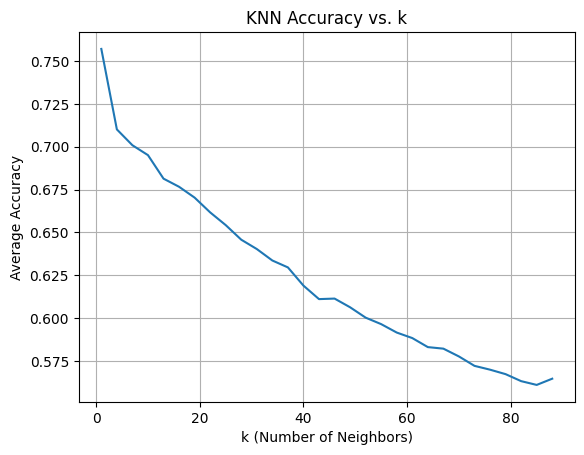

In [ ]:
#THIS PRINTS K VALUES FROM 1-91 TAKES LONG TIME
#JUST FOR TESTING DATA

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

def knn_classifier(k):
    def knn_classify(x_train, y_train, x_test):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train, y_train)
        return knn.predict(x_test)
    return knn_classify

# Range of k values (every 3rd from 1 to 91)
ks = np.arange(1, 91, 3)
acc_list = []


for k_cur in ks:
    my_knn = knn_classifier(k_cur)
    acc = avg_accuracy(my_knn, x_test, y_test)
    acc_list.append(acc)

#debug
print(acc_list[:5])

#Takes a while to run so be prepared
sns.lineplot(x=ks, y=acc_list)
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Average Accuracy")
plt.title("KNN Accuracy vs. k")
plt.grid(True)
plt.show()


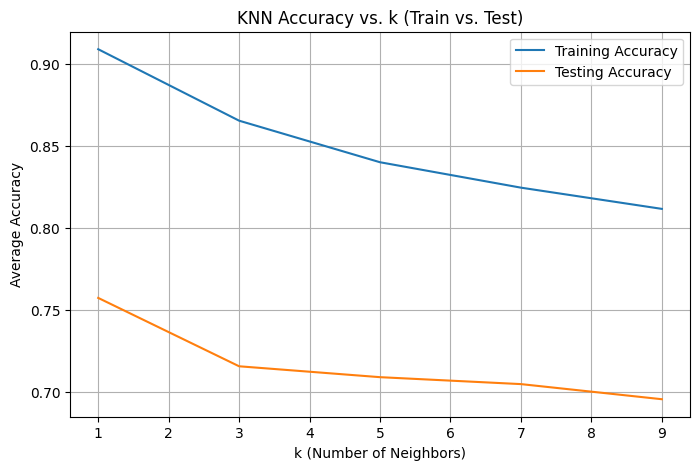

In [ ]:
#chose only a few k values based on graph
ks = np.array([1, 3, 5, 7, 9])
train_acc_list = []
test_acc_list = []


for k_cur in ks:
    my_knn = knn_classifier(k_cur)
    train_acc = avg_accuracy(my_knn, x_train, y_train)
    test_acc = avg_accuracy(my_knn, x_test, y_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

# Plot both accuracies
plt.figure(figsize=(8, 5))
sns.lineplot(x=ks, y=train_acc_list, label='Training Accuracy')
sns.lineplot(x=ks, y=test_acc_list, label='Testing Accuracy')
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Average Accuracy")
plt.title("KNN Accuracy vs. k (Train vs. Test)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#based on observation k value of 3 looks the best but can run anything
my_knn = knn_classifier(3)
accuracy = avg_accuracy(my_knn, x_test, y_test)
print(f"Accuracy with k=3: {accuracy:.4f}")

Accuracy with k=3: 0.7172
